In [1]:
## based on https://dynetworkx.readthedocs.io/en/latest/tutorial.html
import dynetworkx as dnx
import networkx as nx

import numpy as np
from numpy.random import PCG64
# use matplotlib to visualize graph?
# see https://www.geeksforgeeks.org/python-visualize-graphs-generated-in-networkx-using-matplotlib/
%matplotlib notebook        
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # plot in 3D

######## IMPORT MY OWN MODULES ########
from trajectory import *          # import the ability to quickly calculate arm trajectory
from plotStates_updated import *  # import module to plot % time each arm is in each state


In [2]:
### environment constants
x_lim    = [0.2, 0.9]
y_lim    = [0., 10.]
z_lim    = [0., 2.7]

# for the fruit distribution, want to keep it the same for these tests
x_seed = PCG64(37428395352013185889194479428694397783)
y_seed = PCG64(13250124924871709375127216220749555998)
z_seed = PCG64(165440185943501291848242755689690423219)

# density of "fruit" in the orchard
density = 10


### robot constants
n_arm  = 3   # K in melon paper
n_cell = 3   # keeping it simple for now

total_arms = n_arm*n_cell

# vehicle speed
v = 0.08   # in m/s 

# 'fruit handling time window,' a constant worst case value (for now)
Tw_con = 5.     # in sec

# cell width/height (perpendicular to movement) and length (parallel to movement)
cell_h = (z_lim[1] - z_lim[0]) / n_cell  # w in paper
cell_l = 0.2                  # length of individual arm cell 

# arm starting locations
arm_location = np.zeros([n_cell, n_arm, 3])
offset       = 0.2

arm_location[:,:,0] = 0. # x-coordinate start
arm_location[:,:,1] = np.linspace(0, n_arm*offset, n_arm, endpoint=True)

for n in range(n_cell):
    arm_location[n,:,2] = 0. + n*cell_h # z-coordinate start
    
    
# for k in range(n_arm):
#     # set the arms at their respective starting y-coord locations based on offset
#     arm_location[k,1] = k*offset # y-coordinate start -> assumes #0 is at the back, rest of code doesn't
    
# print(arm_location)

In [3]:
## Interval graph node setup
class fruitNode:
    def __init__(self, i, j, k, n, t): 
        # ith fruit
        self.i  = i
        # jth fruit picked by this arm
        self.j  = j
        # arm for which edges are being calculated
        self.k  = k
        # arm's pool/horizontal row
        self.n  = n
        # jth fruit i that the arm k has picked up, denoted t^{k}_{i(j)}, previous fruit 
        # would be t^{k}_{i(j-1)}
        # time at which kth arm reaches the jth fruit it has picked up
        self.t  = t 

In [4]:
## Functions
def calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z):
    '''
       Calculate Tm (moving time -> move in y,z to next fruit) for node i for arm k.
    '''
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate move in y-axis
    traj_calc.adjInit(start_y, 0.) # start moving from zero speed
    traj_calc.noJerkProfile(traj_calc.q0, fruit_y, traj_calc.v0, v_max, a_max, d_max)
    
    t_y = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(start_z, 0.) 
    traj_calc.noJerkProfile(traj_calc.q0, fruit_z, traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate which will dominate
    Tm = max(t_y, t_z)
    
    return(Tm)


def calcTw(traj_calc, fruit_x, fruit_z, bottom_z):
    '''
       Calculate handling time -> extension + pick time + retraction + conveyor drop off 
       for node i. Seperated into two values, before picking (Td0) and after picking (Td1) 
    '''
    # constants
    t_grab = 0.1 
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate extension (retraction)
    traj_calc.adjInit(0., 0.)      # starts at zero for x each time (extend to fruit)
    traj_calc.noJerkProfile(traj_calc.q0, fruit_x, traj_calc.v0, v_max, a_max, d_max)
    
    t_x = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(fruit_z, 0.) # starts at fruit's location (move to conveyor from fruit)
    traj_calc.noJerkProfile(traj_calc.q0, bottom_z, traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # add them together to get before picking and after picking
    Td0 = t_grab + t_x
    Td1 = t_x + t_z
    
    return([Td0, Td1])


def intervalGraph(k, ystart, ystop, color='b'):
    '''Interval graph of the edges with given k arm and color.''' 
    # plot the interval
    plt.hlines(k, ystart, ystop, color, lw=4)
    # plots the whiskers/ends
    plt.vlines(ystart, k+0.03, k-0.03, color, lw=2)
    plt.vlines(ystop, k+0.03, k-0.03, color, lw=2)


In [5]:
## Create fruit data set
len_x = x_lim[1] - x_lim[0]            
len_y = y_lim[1] - y_lim[0]  
len_z = z_lim[1] - z_lim[0]

numFruit = int(density * (len_y*len_x*len_z))  

x = np.random.default_rng(x_seed).uniform(x_lim[0], x_lim[1], numFruit)
y = np.random.default_rng(y_seed).uniform(y_lim[0], y_lim[1], numFruit)
z = np.random.default_rng(z_seed).uniform(z_lim[0], z_lim[1], numFruit)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x, y, z])

axis_to_sort = np.argsort(y) # sort based on y-axis
sortedFruit = fruit[:,axis_to_sort]

# print(sortedFruit)

# create an array (or list if it'll need to be dynamic later) for node objects
# node_array  = np.ndarray(numFruit+n_arm, dtype=object)  # numFruit+arm_node for the initial dummy nodes for each arm
node_array  = np.ndarray(numFruit+total_arms, dtype=object)  # numFruit+arm_node for the initial dummy nodes for each arm

In [6]:
## Initialize the interval graph
IG = dnx.IntervalGraph()

# arm settings, also in calcTd function
v_max = 0.8
a_max = 3.1
d_max = a_max

t_grab = 0.1

## initialize the ability to calculate trajectory
traj_calc = Trajectory(v_max, a_max, d_max)

In [7]:
## (a) initialize dummy 0 nodes for each arm k in each horizontal row
n = -1
for k in range(total_arms): 
    k_pool = k % n_arm
    if k_pool == 0:
        n += 1
#     print('n:', n, 'k_pool:', k_pool)
    
    # node array's index will go from k = 0, 1, ... , total_arms (all the 0th values for each arm)
    node_array[k] = fruitNode(0, 0, k_pool, n, 0)
    IG.add_node(node_array[k])
    
# IG.nodes(data=True) # show the attributes for each node (maybe not necessary)
print('did the dummy node for k=1 get created?', IG.has_node(node_array[1]))
print('k value for dummy node for k=1 (should be = 1):', node_array[1].k)

# set all fruit as unpicked
for i in range(numFruit):
#     node_array[i+n_arm] = fruitNode(i, 0, n_arm, 0) # k = n_arm which is > n-1 (index) to identify unpicked fruit
    node_array[i+total_arms] = fruitNode(i, 0, n_arm, n_cell, 0) # k = n_arm which is > n-1 (index) to identify unpicked fruit
    # actual fruit will also be set to non-existent pool (n_cell > range(n_cell))
#     IG.add_node(node_array[i+n_arm])
    IG.add_node(node_array[i+total_arms])
    
print('number of fruit:', numFruit)    
print('number of nodes after adding all zero nodes for the arms:', len(IG.nodes()))

did the dummy node for k=1 get created? True
k value for dummy node for k=1 (should be = 1): 1
number of fruit: 189
number of nodes after adding all zero nodes for the arms: 198


In [8]:
'''Randomly shuffle an array of arm indexed for potential load balancing'''

# a = range(n_arm)
# print(a)
# b = np.array(a)
# print(b)
# random.shuffle(b)
# print(b)

'Randomly shuffle an array of arm indexed for potential load balancing'

In [17]:
'''
   Creating time intervals for each fruit for each arm in the cell based on fruit location: when the arm 
   can pick it and how long extension+grab+retract+drop off of fruit will take without running through fruit 
   list for every pool/horizontal row
'''
# figure out what fruit get matched to each row based on z-axis location
edge_list = list()
k_edges   = list()
Tw_values = list() # the same value for every arm, separated into Tw0 (extend+grab) and Tw1 (retract+drop off)

# edges for the nth horizontal row of cells
# row bottom edge = n*cell_h
row_bot_edge = np.linspace(0, (n_cell*cell_h - cell_h), n_cell, endpoint=True)
# row_top_edge = row_bot_edge + cell_h
row_top_edge = np.copy(row_bot_edge) + cell_h
# print('each bottom frame z-val:', row_bot_edge)
# print('each top frame z-val:', row_top_edge)

for n in range(n_cell):
    edge_list.append([])
#     Tw_values.append([]) 
    
for index, y_i in enumerate(sortedFruit[1]):
    # check that the zi value is available to the nth horizontal row of cells
        
    ## calculate pool/horizontal, n, row value by comparing zi vs cell height 
    n = math.floor(sortedFruit[2,index] / cell_h)
#     print(n)

    ## can set fruit node's pool value here:
    node_array[index+total_arms].n = n
    
    # calculate y_i / v which is constant for this fruit

    # handling time will be constant here, based on the pool's/row's bottom edge
    [Tw0, Tw1] = calcTw(traj_calc, sortedFruit[0,index], sortedFruit[2,index], row_bot_edge[n])
    Tw_values.append([Tw0, Tw1]) # save values since it will be used to calc picking time later
    ## Tw based on fruit i, and it will be based on which horizontal row it fits in (row_bot_edge[n]) but 
    #   not saved by row (n)

    Tw = Tw0 + Tw1

    # values of fruit location at the start and end, as well as the handling time
    t_start_0 = y_i / v - Tw # adding the calculated handling time 
    t_end_0   = y_i / v      # the end time will be when the back frame is reached by the fruit 

    k_edges.append(index)
        
    for k in range(n_arm):
        # add the offset based on the arm number (assuming back arm is k=0 to front arm k=n_arm)
#         offset = (cell_l*(k+1)) / v  # (k+1) to indicate it's the front frame location we're looking for
        offset = (cell_l*k) / v  # looking at the back part of the frame 

        ## Saying here that the fruit can only be picked if arm is not busy when the front of the frame reaches t
        #  the fruit

        t_start_k = t_start_0 - offset
        t_end_k   = t_end_0 - offset

        ### NOTE: check if interval too long versus the amount of time fruit is in cell (t = cell_l/v)      
        if t_start_k > 0 and t_end_k > 0 and t_end_k - (t_start_k + Tw0) < cell_l/v:
            # the interval has to be positive or it cannot be used (impossible to pick that fruit)
            k_edges.append([k, t_start_k, t_end_k])


    if len(k_edges) > 1:
#         print(k_edges)
        edge_list[n].append(k_edges.copy()) # if not a copy, values in edge_list also get deleted in next line

    # delete values in k_edges
    del k_edges[:]

for n in range(n_cell):
    print(edge_list[n])
    print()
# print(edge_list[0]) # prints pool 0 time intervals

[[11, [0, 5.117426129638707, 7.311463244126806], [1, 2.617426129638707, 4.811463244126806], [2, 0.11742612963870691, 2.3114632441268057]], [19, [0, 9.394213650910974, 11.848123652981698], [1, 6.894213650910974, 9.348123652981698], [2, 4.394213650910974, 6.848123652981698]], [21, [0, 12.139002779014191, 15.156808891219148], [1, 9.639002779014191, 12.656808891219148], [2, 7.1390027790141914, 10.156808891219148]], [23, [0, 13.388058989744145, 16.88118174883489], [1, 10.888058989744145, 14.38118174883489], [2, 8.388058989744145, 11.88118174883489]], [24, [0, 15.746667581115588, 17.81085249147486], [1, 13.246667581115588, 15.310852491474861], [2, 10.746667581115588, 12.810852491474861]], [25, [0, 15.372992361706514, 18.139025124520895], [1, 12.872992361706514, 15.639025124520895], [2, 10.372992361706514, 13.139025124520895]], [27, [0, 18.544065046453543, 20.867992552484797], [1, 16.044065046453543, 18.367992552484797], [2, 13.544065046453543, 15.867992552484797]], [28, [0, 18.19864345528219

In [10]:
'''now have to figure out which arm in which pool picks what fruit based on previously calculated time intervals'''

# (b) process nodes in order of increasing y-coord
# Td = np.zeros(n_arm)
t  = np.zeros([n_cell, n_arm, numFruit+1]) # t of arm k when *finished picking* (Tm+Td) fruit i

# save Tm values for state % plot
Tm_values = list()

last_i = np.ndarray([n_cell, n_arm], dtype=object)
curr_j = np.ndarray([n_cell, n_arm], dtype=object)

for n in range(n_cell):
    Tm_values.append([])
    
    for k in range(n_arm):
        Tm_values[n].append([])
#         print('should be 0, 1, 2, ...., total arms:', k+(n*3))
        real_index = k + (n*n_arm)
        # saves the fruit id of the fruit last picked by the kth arm in pool n
        last_i[n,k] = node_array[real_index]
        # saves the current number of picked fruit by the kth arm in pool n
        curr_j[n,k] = node_array[real_index].j

# update this for when there are more/less than three arms
# last_i = np.array([node_array[0], node_array[1], node_array[2]]) # saves the fruit id of the fruit last picked by the arm k 
# curr_j = np.array([node_array[0].j, node_array[1].j, node_array[2].j]) # saves the number of fruit being picked by 
# the kth arm

for n in range(n_cell):
        # the edge list has been separated by pool/row already
    for e in edge_list[n]:
        i   = e[0] ## causes below k+1 because e[0] is i (fruit num) 
        
        arm_index_list = np.array(range(len(e)-1))
        # create a randomized list of potential arms
        random.shuffle(arm_index_list)
        print('for fruit', i, 'arm list:', arm_index_list)

#         for k in range(len(e)-1):
        for k in arm_index_list:
            # the arm number (changes based on how many intervals had negative values) 
            # => not all arms could pick fruit
    #         print('arm number', k)
    #         print('start:', e[k+1][1], 'end:', e[k+1][2]) 

            # take the previously chosen i for arm k and add in the move time to new i
            prev = sortedFruit[1, last_i[n,k].i] 
            # calculate how far the vehicle moves between the interval end of y_(i-1) and interval start of y_i
            # also removes the Td/Tw after picking value (won't move in y after that)
            veh_move = (e[k+1][1] - (last_i[n,k].t - Tw_values[i][1]))*v  ### coming up negative sometimes?

            # move to new location arrived when moving to get the next fruit
            # ends in line with previous fruit plus the distance the vehicle moves between the end time of last fruit
            # and the beginning time of this one
            start_y = prev + veh_move      
            start_z = row_bot_edge[n]   # ends at the bottom of horizontal row to drop off the fruit

            print('y_(i-1):', prev, 'y_i:', sortedFruit[1,i])
            print('new y(i-1):', start_y, 'since vehicle moves:', veh_move)

            # new fruit's location
            fruit_y = sortedFruit[1,i]
            fruit_z = sortedFruit[2,i]

            # calculate how long it would take to reach new fruit
            Tm = calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z)

            start_time = e[k+1][1] - Tm # add movement into work before handling to get the true total time interval

            # careful with reference, the return should actually be ((u,v), begin, end)
            # https://dynetworkx.readthedocs.io/en/latest/reference/classes/generated/dynetworkx.IntervalGraph.edges.html#dynetworkx.IntervalGraph.edges              
            n_interval = IG.edges(begin=start_time, end=e[k+1][2]) # check if there are edges that lie between the new edges?
            print('number of intervals that fall within the current calculated edges',len(n_interval))

            is_busy    = IG.edges(v=last_i[n,k], begin=start_time, end=e[k+1][2])
            print('is arm', k, 'in pool', n, 'already busy for this interval?', len(is_busy))

#             if len(n_interval) < n_arm and len(is_busy) < 1: 
            if len(is_busy) < 1: 
                # add an edge between the last node and this node with interval edge U
                print('      add edge')
    #             IG.add_edge(last_i[k], node_array[i+n_arm], e[k+1][1], e[k+1][2])
                IG.add_edge(last_i[n,k], node_array[i+total_arms], start_time, e[k+1][2])

                # update the node
                node_array[i+total_arms].j = curr_j[n,k] + 1
                node_array[i+total_arms].k = k
                node_array[i+total_arms].t = e[k+1][2] 

                # save the Tm value for state plot
                Tm_values[n][k].append(Tm)

                # update all the saved prev node data
                last_i[n,k] = node_array[i+total_arms]
                curr_j[n,k] = node_array[i+total_arms].j # maybe don't need to save this array, just use last_i

                # skip this fruit for the rest of the arms
                print()
                break

for fruit 11 arm list: [1 2 0]
y_(i-1): 0.005292470942258598 y_i: 0.5849170595301445
new y(i-1): 0.3239048608017333 since vehicle moves: 0.3186123898594747
number of intervals that fall within the current calculated edges 0
is arm 1 in pool 0 already busy for this interval? 0
      add edge

for fruit 19 arm list: [2 1 0]
y_(i-1): 0.005292470942258598 y_i: 0.9478498922385359
new y(i-1): 0.47763911439199913 since vehicle moves: 0.47234664344974053
number of intervals that fall within the current calculated edges 1
is arm 2 in pool 0 already busy for this interval? 0
      add edge

for fruit 21 arm list: [0 2 1]
y_(i-1): 0.005292470942258598 y_i: 1.2125447112975318
new y(i-1): 1.1426915515821816 since vehicle moves: 1.137399080639923
number of intervals that fall within the current calculated edges 0
is arm 0 in pool 0 already busy for this interval? 0
      add edge

for fruit 23 arm list: [0 2 1]
y_(i-1): 1.2125447112975318 y_i: 1.3504945399067914
new y(i-1): 1.2323274860523834 since 

y_(i-1): 4.647295683213262 y_i: 4.837726399343969
new y(i-1): 4.732625410348926 since vehicle moves: 0.08532972713566438
number of intervals that fall within the current calculated edges 2
is arm 1 in pool 0 already busy for this interval? 1
y_(i-1): 4.620854982155177 y_i: 4.837726399343969
new y(i-1): 4.732625410348926 since vehicle moves: 0.1117704281937489
number of intervals that fall within the current calculated edges 4
is arm 2 in pool 0 already busy for this interval? 1
for fruit 96 arm list: [2 1 0]
y_(i-1): 4.620854982155177 y_i: 5.174763986781999
new y(i-1): 5.120484617569986 since vehicle moves: 0.4996296354148086
number of intervals that fall within the current calculated edges 0
is arm 2 in pool 0 already busy for this interval? 0
      add edge

for fruit 99 arm list: [1 2 0]
y_(i-1): 4.647295683213262 y_i: 5.227030812244765
new y(i-1): 5.1713910809924055 since vehicle moves: 0.5240953977791435
number of intervals that fall within the current calculated edges 0
is arm 1 

y_(i-1): 0.8726731700654378 y_i: 2.1706966655862168
new y(i-1): 2.121995455762513 since vehicle moves: 1.2493222856970752
number of intervals that fall within the current calculated edges 3
is arm 0 in pool 1 already busy for this interval? 0
      add edge

for fruit 43 arm list: [2 1 0]
y_(i-1): 2.098861545349695 y_i: 2.5754731020644406
new y(i-1): 2.4966579660201136 since vehicle moves: 0.39779642067041837
number of intervals that fall within the current calculated edges 4
is arm 2 in pool 1 already busy for this interval? 0
      add edge

for fruit 45 arm list: [2 0 1]
y_(i-1): 2.5754731020644406 y_i: 2.650914564716258
new y(i-1): 2.5957900219535044 since vehicle moves: 0.020316919889063742
number of intervals that fall within the current calculated edges 5
is arm 2 in pool 1 already busy for this interval? 1
y_(i-1): 2.1706966655862168 y_i: 2.650914564716258
new y(i-1): 2.595790021953504 since vehicle moves: 0.42509335636728707
number of intervals that fall within the current cal

number of intervals that fall within the current calculated edges 5
is arm 1 in pool 1 already busy for this interval? 0
      add edge

for fruit 141 arm list: [2 1 0]
y_(i-1): 6.260160158947575 y_i: 7.199974062418972
new y(i-1): 7.084841960688563 since vehicle moves: 0.8246818017409885
number of intervals that fall within the current calculated edges 7
is arm 2 in pool 1 already busy for this interval? 0
      add edge

for fruit 143 arm list: [1 2 0]
y_(i-1): 7.182490499822842 y_i: 7.245790832674982
new y(i-1): 7.160159747008172 since vehicle moves: -0.02233075281466995
number of intervals that fall within the current calculated edges 6
is arm 1 in pool 1 already busy for this interval? 1
y_(i-1): 7.199974062418972 y_i: 7.245790832674982
new y(i-1): 7.160159747008172 since vehicle moves: -0.03981431541080042
number of intervals that fall within the current calculated edges 7
is arm 2 in pool 1 already busy for this interval? 1
y_(i-1): 7.117534193927951 y_i: 7.245790832674982
new y(

for fruit 41 arm list: [1 2 0]
y_(i-1): 1.9090042294062326 y_i: 2.357944494785867
new y(i-1): 2.2627395078720203 since vehicle moves: 0.35373527846578784
number of intervals that fall within the current calculated edges 6
is arm 1 in pool 2 already busy for this interval? 0
      add edge

for fruit 42 arm list: [2 0 1]
y_(i-1): 1.9177291693816667 y_i: 2.4473582667432003
new y(i-1): 2.3297607122622463 since vehicle moves: 0.4120315428805796
number of intervals that fall within the current calculated edges 6
is arm 2 in pool 2 already busy for this interval? 0
      add edge

for fruit 44 arm list: [2 0 1]
y_(i-1): 2.4473582667432003 y_i: 2.5945114929436244
new y(i-1): 2.529954480231726 since vehicle moves: 0.08259621348852562
number of intervals that fall within the current calculated edges 8
is arm 2 in pool 2 already busy for this interval? 1
y_(i-1): 1.6244301636045178 y_i: 2.5945114929436244
new y(i-1): 2.529954480231726 since vehicle moves: 0.9055243166272083
number of intervals t

In [22]:
print('Total number of fruit:', numFruit)
print('Vehicle velocity:', v, 'm/s')
print()
print('Total harvested fruit:', np.sum(curr_j), 'or', np.sum(curr_j)/numFruit)
print('Total fruit / total vehicle run time:', np.sum(curr_j) / ((y_lim[1] - y_lim[0]) / v), 'fruit/sec')
print()

for n in range(n_cell):
    arm_string = ''
    for k in range(n_arm):
        arm_string += ' arm ' + str(k) + ': ' + str(curr_j[n,k]) + ' '
        
    print('Number of fruit picked by pool', n, arm_string)


Total number of fruit: 189
Vehicle velocity: 0.08 m/s

Total harvested fruit: 145 or 0.7671957671957672
Total fruit / total vehicle run time: 1.16 fruit/sec

Number of fruit picked by pool 0  arm 0: 15  arm 1: 18  arm 2: 18 
Number of fruit picked by pool 1  arm 0: 15  arm 1: 17  arm 2: 13 
Number of fruit picked by pool 2  arm 0: 17  arm 1: 18  arm 2: 14 


In [12]:
IG.edges()

fruit_picked_by = list()
for n in range(n_cell):
    fruit_picked_by.append([])
    for k in range(n_arm+1):
        fruit_picked_by[n].append([])

for i in range(total_arms, numFruit+total_arms):
#     print('row number:', node_array[i].n, 'arm number:', node_array[i].k)
    fruit_picked_by[node_array[i].n][node_array[i].k].append(node_array[i].i)

print(fruit_picked_by)

[[[21, 27, 36, 47, 66, 71, 77, 86, 108, 115, 129, 137, 148, 158, 172], [11, 24, 29, 37, 54, 63, 73, 89, 99, 104, 111, 117, 128, 146, 156, 164, 173, 178], [19, 23, 28, 38, 51, 64, 69, 78, 87, 96, 107, 113, 123, 130, 145, 154, 174, 183], [10, 17, 25, 31, 39, 40, 57, 67, 90, 91, 92, 136, 150, 175]], [[5, 15, 35, 45, 55, 75, 102, 116, 122, 133, 155, 161, 171, 176, 185], [9, 14, 20, 48, 61, 72, 83, 97, 106, 110, 119, 140, 149, 157, 159, 169, 179], [33, 43, 49, 60, 74, 95, 103, 109, 118, 141, 160, 170, 180], [3, 6, 34, 50, 52, 58, 59, 80, 81, 121, 124, 143, 162, 163, 166, 167, 181, 186, 187]], [[8, 18, 26, 44, 56, 65, 70, 82, 94, 100, 114, 125, 131, 144, 151, 165, 182], [7, 16, 30, 41, 46, 62, 68, 79, 85, 88, 93, 101, 120, 127, 135, 152, 168, 184], [12, 22, 32, 42, 53, 76, 84, 98, 112, 126, 132, 147, 153, 177], [0, 1, 2, 4, 13, 105, 134, 138, 139, 142, 188]]]


<IPython.core.display.Javascript object>


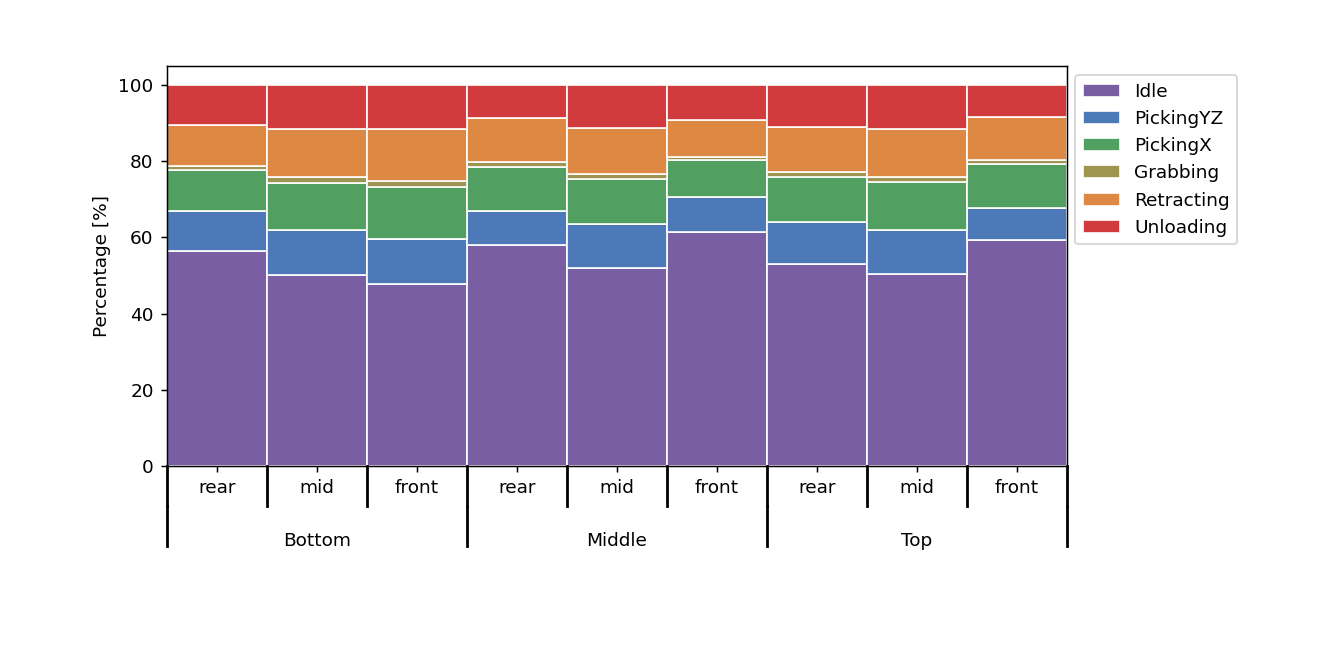

In [13]:
'''Plot the percent time each arm is in each state'''
total_time = (y_lim[1] - y_lim[0]) / v

## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
state_percent = np.zeros([total_arms, 6]) # save each arm's percent time in each of the six states 

for n in range(n_cell):
    for k in range(n_arm):
        tot_arm_index = k + (n*n_arm)
        # calculate arm's move_yz using Tm
        for tm in Tm_values[n][k]:
            state_percent[tot_arm_index,1] += tm

        for i in fruit_picked_by[n][k]:  
#             print(Tw_values[i])

            # calculate extend from Tw0 and final j for each arm k       
            move_x = Tw_values[i][0] - t_grab
            state_percent[tot_arm_index,2] += move_x

            # calculate grab from Tw and final j for each arm k
            state_percent[tot_arm_index,3] += t_grab

            # calculate unload from Tw1 and final j for each arm k
            state_percent[tot_arm_index,5] += Tw_values[i][1] - move_x

        # since this is ideal, retract == extend
        state_percent[tot_arm_index,4] = state_percent[tot_arm_index,2]

        # calculate idle by subtracting all before by total time: length_row / v
        state_percent[tot_arm_index,0] = total_time - np.sum(state_percent[tot_arm_index,:])

        state_percent[tot_arm_index,:] = (state_percent[tot_arm_index,:] / total_time) * 100

#         print('For arm', tot_arm_index,)
#         print('idle:', state_percent[tot_arm_index,0], 'pick_yz:', state_percent[tot_arm_index,1], 
#               'pick_x', state_percent[tot_arm_index,2], 'grab:', state_percent[tot_arm_index,3], 'retract_x:', 
#               state_percent[tot_arm_index,4], 'unload:', state_percent[tot_arm_index,5])

        # does each k's state % add up to 100%?
        percent_sum = np.sum(state_percent[tot_arm_index,:])
#         print('Sum total of all percentages', percent_sum)
#         print()

state_percent_transpose = state_percent
    
state_percent_list = state_percent_transpose.tolist()
# print(state_percent_list)
plot_states = plotStates(state_percent_list)


<IPython.core.display.Javascript object>


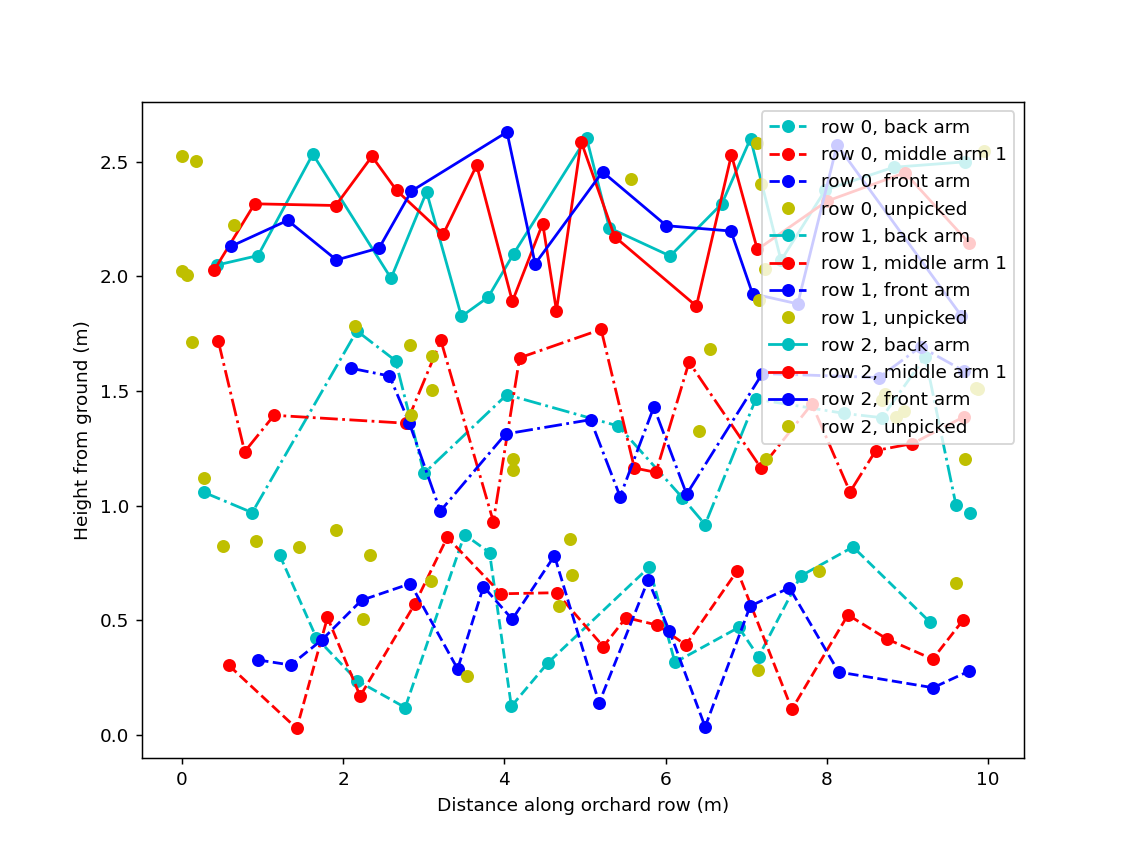

In [14]:
fig, ax = plt.subplots()

line_type = ['--', '-.', '-', '.']
color     = ['c', 'r', 'b', 'g']


for n in range(n_cell):
    for k in range(n_arm+1):
        # add modulo later so it works with n and k > 3 
        if k == n_arm:
            line = 'oy'
            arm_label = 'row ' + str(n) + ', unpicked'
        elif k == 0:
            line = 'o' + line_type[n] + color[k]
            arm_label = 'row ' + str(n) + ', back arm'
        elif k == n_arm-1:
            line = 'o' + line_type[n] + color[k]
            arm_label = 'row ' + str(n) + ', front arm'
        else:
            line = 'o' + line_type[n] + color[k]
            arm_label = 'row ' + str(n) + ', middle arm ' + str(k)
            
        plt.plot(sortedFruit[1][fruit_picked_by[n][k]], 
                 sortedFruit[2][fruit_picked_by[n][k]], line, label=arm_label)

plt.xlabel('Distance along orchard row (m)')
plt.ylabel('Height from ground (m)')

legend = ax.legend(loc='upper right')
                   
plt.show()

<IPython.core.display.Javascript object>


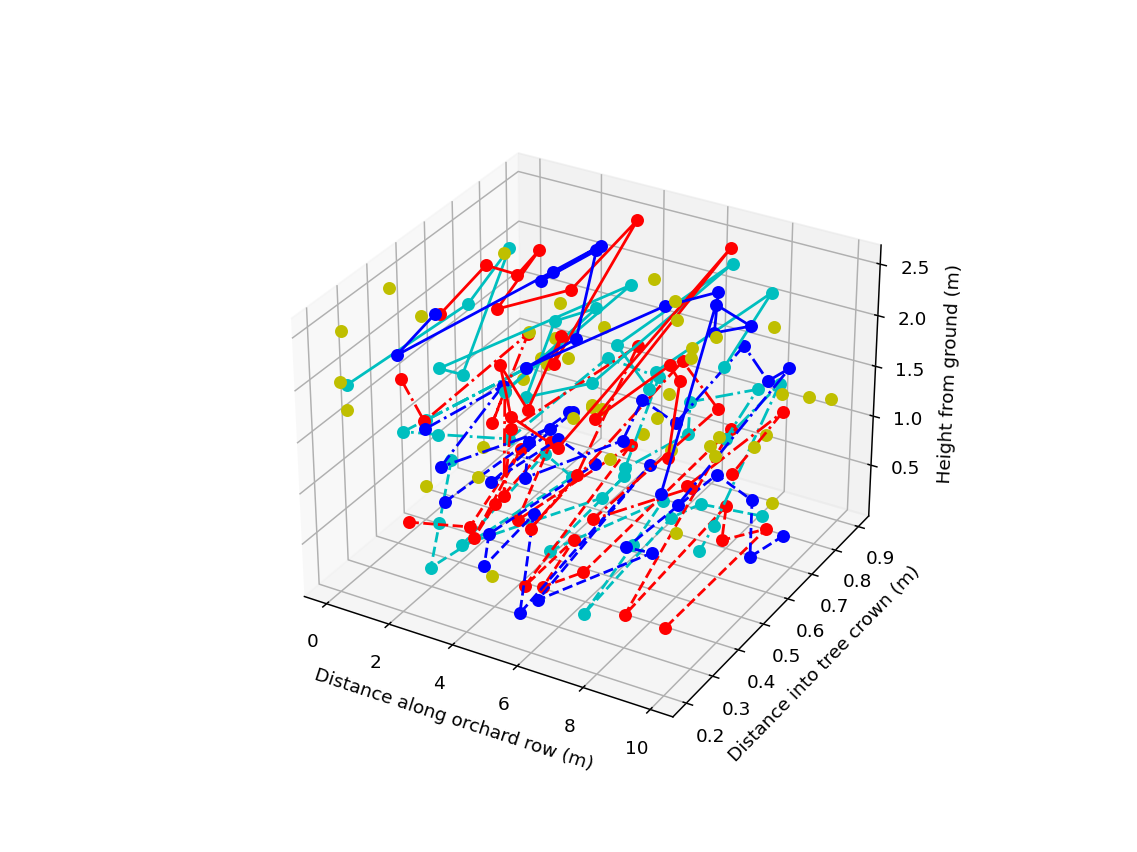

In [15]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

for n in range(n_cell):
    for k in range(n_arm+1):
        # add modulo later so it works with n and k > 3 
        if k == n_arm:
            line = 'oy'
            arm_label = 'row ' + str(n) + ', unpicked'
        elif k == 0:
            line = 'o' + line_type[n] + color[k]
            arm_label = 'row ' + str(n) + ', back arm'
        elif k == n_arm-1:
            line = 'o' + line_type[n] + color[k]
            arm_label = 'row ' + str(n) + ', front arm'
        else:
            line = 'o' + line_type[n] + color[k]
            arm_label = 'row ' + str(n) + ', middle arm ' + str(k)
            
        plt.plot(sortedFruit[1][fruit_picked_by[n][k]], 
                 sortedFruit[0][fruit_picked_by[n][k]],
                 sortedFruit[2][fruit_picked_by[n][k]], line, label=arm_label)

ax.set_xlabel('Distance along orchard row (m)')
ax.set_ylabel('Distance into tree crown (m)')
ax.set_zlabel('Height from ground (m)')

plt.show()

In [16]:
# '''Plot the intervals -- Testing time not distance intervals'''
# # based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# # plot is based on time...
# fig, ax = plt.subplots()

# for e in IG.edges():
#     if e[1].k == 0:
#         intervalGraph(e[1].k, e[2], e[3], color='c')
#     elif e[1].k == 1:
#         intervalGraph(e[1].k, e[2], e[3], color='r')
#     elif e[1].k == 2:
#         intervalGraph(e[1].k, e[2], e[3], color='b')

# plt.xlabel('Time (sec)')
# plt.ylabel('Arm number')
        
# plt.show()